In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pyarrow.parquet as pq
import gc
from tqdm import tqdm


class FeatureCorrelationAnalyzer:
    """考虑编码反编码的特征相关性分析类"""
    
    def __init__(self, logger=None):
        self.logger = logger
        self.original_bin_edges = {}  # 存储分箱边界
        
    def load_data(self, file_path, sample_size=None):
        """加载数据（假设数据已编码）"""
        if self.logger:
            self.logger.info(f"开始加载数据: {file_path}")
        
        if file_path.endswith('.parquet'):
            pf = pq.ParquetFile(file_path)
            df = pf.read().to_pandas()
            if self.logger:
                self.logger.info(f"开始加载Parquet文件: {file_path}")
            if sample_size:
                df = next(pf.iter_batches(batch_size=sample_size)).to_pandas()            
                                
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            if self.logger:
                self.logger.info(f"开始加载CSV文件: {file_path}")
                
        else:
            raise ValueError("不支持的文件格式")
        return df
    
    def reverse_encoding(self, df):
        """
        对需要反编码的特征进行处理
        返回:
        - df: 处理后的DataFrame
        - reverse_info: 反编码信息（用于解释结果）
        """
        reverse_info = {}
        
        # 1. 处理哈希编码的字符串特征
        hash_encoded_cols = [
            col for col in df.columns 
            if any(x in col for x in [
                'Carrier_code', 'airport_iata', 'aircraft_code', 
                'flightNumber', 'frequentFlyer'
            ])
        ]
        
        for col in hash_encoded_cols:
            if col in df.columns:
                # 转换为分类标签（虽然不能还原原始值，但比哈希值更易解释）
                le = LabelEncoder()
                df[col+'_label'] = le.fit_transform(df[col].astype(str))
                reverse_info[col] = {
                    'type': 'hash_encoded',
                    'mapping': dict(zip(le.classes_, le.transform(le.classes_)))
                }
        
        # 2. 处理分箱编码特征（保留分箱信息）
        if 'taxes_bin' in df.columns:
            # 假设原始分箱是等频分箱，计算分位数
            if 'taxes' not in df.columns:  # 如果原始值不存在
                bins = 10
                self.original_bin_edges['taxes'] = np.linspace(
                    df['taxes_bin'].min(), df['taxes_bin'].max(), bins+1)
                df['taxes_bin_mid'] = pd.cut(
                    df['taxes_bin'], bins=bins,
                    labels=[f"{self.original_bin_edges['taxes'][i]:.1f}-{self.original_bin_edges['taxes'][i+1]:.1f}" 
                           for i in range(bins)])
                reverse_info['taxes_bin'] = {
                    'type': 'binned',
                    'bin_edges': self.original_bin_edges['taxes']
                }
        
        if 'totalPrice_bin' in df.columns:
            if 'totalPrice' not in df.columns:
                bins = 10
                self.original_bin_edges['totalPrice'] = np.linspace(
                    df['totalPrice_bin'].min(), df['totalPrice_bin'].max(), bins+1)
                df['totalPrice_bin_mid'] = pd.cut(
                    df['totalPrice_bin'], bins=bins,
                    labels=[f"{self.original_bin_edges['totalPrice'][i]:.1f}-{self.original_bin_edges['totalPrice'][i+1]:.1f}" 
                           for i in range(bins)])
                reverse_info['totalPrice_bin'] = {
                    'type': 'binned',
                    'bin_edges': self.original_bin_edges['totalPrice']
                }
        
        # 3. 处理ID类特征（作为分类变量）
        id_cols = ['profileId', 'companyID', 'ranker_id']
        for col in id_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')
                reverse_info[col] = {'type': 'id_as_category'}
        
        return df, reverse_info
    
    def analyze_correlation(self, df, target_col='selected', figsize=(20, 15)):
        """执行相关性分析"""
        results = {}
        
        # 1. 准备数值型特征
        numeric_cols = df.select_dtypes(include=[
            'int8', 'int16', 'int32', 'int64', 
            'float16', 'float32', 'float64', 'bool'
        ]).columns.tolist()
        
        # 2. 与目标变量的相关性
        if target_col in df.columns:
            corr_with_target = df[numeric_cols].corr()[target_col].abs().sort_values(ascending=False)
            results['target_correlation'] = corr_with_target
            
            # 可视化
            plt.figure(figsize=(10, 12))
            top_n = min(30, len(corr_with_target)-1)
            corr_with_target[1:top_n+1].sort_values().plot(kind='barh')
            plt.title(f'Top {top_n} Features Correlated with {target_col}')
            plt.tight_layout()
            plt.show()
        
        # 3. 特征间相关性矩阵
        corr_matrix = df[numeric_cols].corr()
        results['correlation_matrix'] = corr_matrix
        
        # 可视化
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                    annot=False, fmt=".2f", 
                    linewidths=0.5, linecolor='gray')
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # 4. 高相关性特征对
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                          for i, j in zip(*np.where(np.abs(upper) > 0.8))]
        
        results['high_correlation_pairs'] = high_corr_pairs
        
        if high_corr_pairs:
            print("\n高度相关的特征对 (|corr| > 0.8):")
            for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:20]:
                print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")
        
        return results
    
    def analyze_categorical_features(self, df, target_col='selected', top_n=10):
        """分析分类特征与目标变量的关系"""
        cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
        
        if not cat_cols or target_col not in df.columns:
            return None
        
        results = {}
        
        for col in cat_cols:
            # 计算每个类别的选择率
            selection_rate = df.groupby(col)[target_col].mean()
            results[col] = selection_rate.sort_values(ascending=False)
            
            # 可视化Top N
            plt.figure(figsize=(10, 6))
            selection_rate.sort_values(ascending=False).head(top_n).plot(kind='bar')
            plt.title(f'Selection Rate by {col} (Top {top_n})')
            plt.ylabel('Selection Rate')
            plt.tight_layout()
            plt.show()
        
        return results
    
    def analyze_single_table(self, file_path, sample_size=50000):
        """分析单个表的完整流程"""
        print(f"\n{'='*50}")
        print(f"开始分析表: {file_path}")
        print(f"{'='*50}")
        
        # 1. 加载数据
        df = self.load_data(file_path, sample_size)
        
        # 2. 反编码处理
        df, reverse_info = self.reverse_encoding(df)
        print("\n反编码信息:")
        for col, info in reverse_info.items():
            print(f"- {col}: {info['type']}")
            if 'bin_edges' in info:
                print(f"  分箱边界: {info['bin_edges']}")
        
        # 3. 数值特征相关性分析
        print("\n数值特征相关性分析...")
        num_results = self.analyze_correlation(df)
        
        # 4. 分类特征分析
        print("\n分类特征分析...")
        cat_results = self.analyze_categorical_features(df)
        
        return {
            'data': df,
            'reverse_info': reverse_info,
            'numeric_results': num_results,
            'categorical_results': cat_results
        }

# 使用示例
if __name__ == "__main__":
    # 定义所有表路径
    table_paths = [
        # "E:/GIT PROJECT/FR/data/aeroclub-recsys-2025/encode/train/train_segment_0_encoded.parquet",
        # "E:/GIT PROJECT/FR/data/aeroclub-recsys-2025/encode/train/train_segment_1_encoded.parquet",
        # "E:/GIT PROJECT/FR/data/aeroclub-recsys-2025/encode/train/train_segment_2_encoded.parquet",
        "cleaned_data.csv"
    ]
    
    analyzer = FeatureCorrelationAnalyzer()
    all_results = {}
    
    for path in table_paths:
        try:
            result = analyzer.analyze_single_table(path, sample_size=None)
            all_results[path] = result
            
            # 保存重要结果
            if 'numeric_results' in result and 'target_correlation' in result['numeric_results']:
                top_features = result['numeric_results']['target_correlation'].head(20)
                print(f"\n表 {path} 中与目标变量相关性最高的20个特征:")
                print(top_features)
                
            # 释放内存
            del result
            gc.collect()
            
        except Exception as e:
            print(f"\n分析表 {path} 时出错: {str(e)}")
            continue
    
    print("\n所有表分析完成!")


开始分析表: cleaned_data.csv

分析表 cleaned_data.csv 时出错: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

所有表分析完成!


检测到CUDA GPU，将启用GPU加速
开始完整分析流程...
开始加载数据: cleaned_data.csv
数据加载完成，形状: (1120750, 125)
准备排名任务数据...
过滤前组数: 5417, 过滤后组数: 5332
过滤前数据量: 1120750, 过滤后数据量: 1120124
有选中项目的组数: 5332
最终数据量: 1120124
分割排名数据...
总共有 5332 个唯一组
训练组数: 4266, 测试组数: 1066
训练集大小: 901186, 测试集大小: 218938

训练排名模型...
训练集组数: 4266, 测试集组数: 1066
训练 XGBRanker...
XGBRanker 训练完成 - HitRate@3: 0.6548, NDCG@3: 0.5325
训练 LGBMRanker...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9506
[LightGBM] [Info] Number of data points in the train set: 901186, number of used features: 110
LGBMRanker 训练完成 - HitRate@3: 0.6998, NDCG@3: 0.5816

=== 模型性能比较 ===
     Model    Type    AUC     F1 Precision Recall HitRate@3 NDCG@3
 XGBRanker Ranking 0.9617 0.0200    0.0101 0.9982    0.6548 0.5325
LGBMRanker Ranking 0.9606 0.0200    0.0101 0.9973    0.6998 

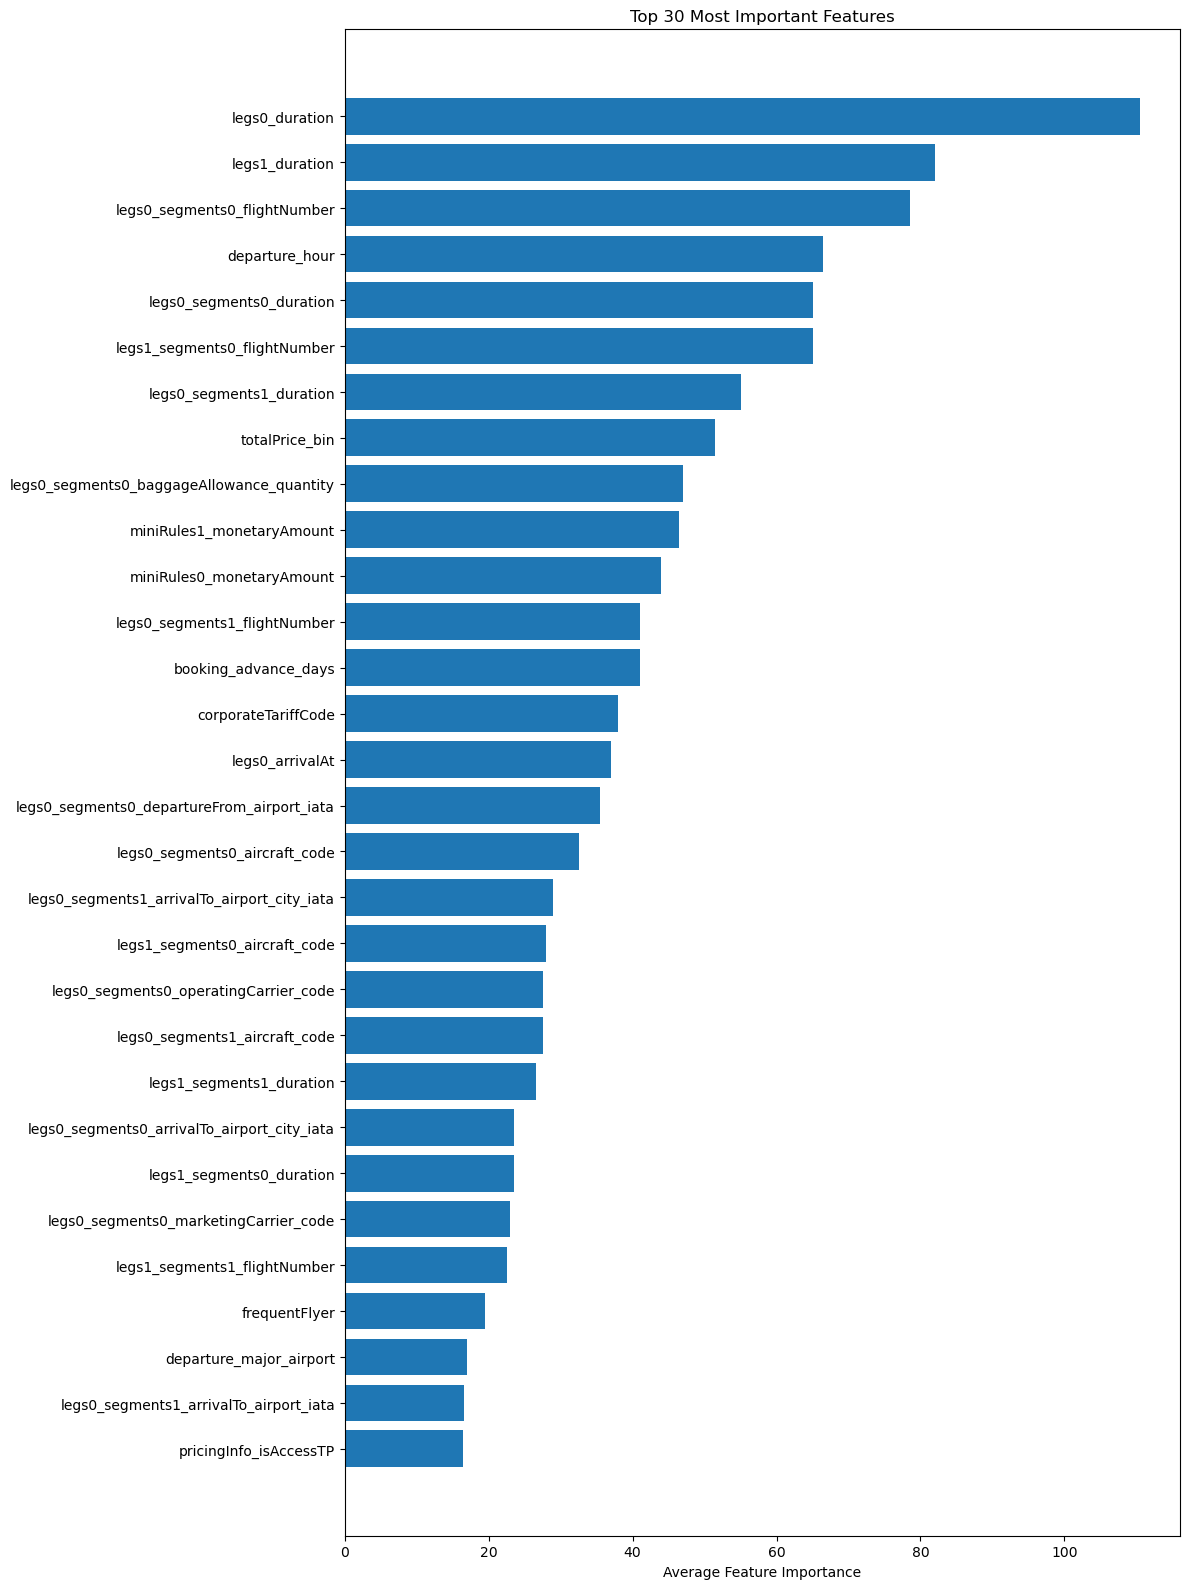


前10个最重要的特征:
 1. legs0_duration: 110.5398
 2. legs1_duration: 82.0161
 3. legs0_segments0_flightNumber: 78.5019
 4. departure_hour: 66.5027
 5. legs0_segments0_duration: 65.0046
 6. legs1_segments0_flightNumber: 65.0024
 7. legs0_segments1_duration: 55.0882
 8. totalPrice_bin: 51.5051
 9. legs0_segments0_baggageAllowance_quantity: 47.0055
10. miniRules1_monetaryAmount: 46.5091

=== 最佳排名模型 ===
模型: LGBMRanker
HitRate@3: 0.6998


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 7: invalid start byte

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRanker
from lightgbm import LGBMClassifier, LGBMRanker
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, ndcg_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
import shap
import pyarrow.parquet as pq
import gc
import warnings
warnings.filterwarnings('ignore')

class FlightRankingAnalyzer:
    """优化版航班排名分析器 - 修复HitRate@3计算和GPU兼容性问题"""
    
    def __init__(self, use_gpu=True, logger=None):
        """
        初始化分析器
        :param use_gpu: 是否使用GPU加速
        :param logger: 日志记录器
        """
        self.logger = logger
        self.use_gpu = use_gpu
        self.original_bin_edges = {}
        
        # 初始化排名模型 - 添加GPU兼容性检查
        self.ranking_models = {
            'XGBRanker': XGBRanker(
                n_estimators=100,
                random_state=42,
                eval_metric='ndcg',
                max_depth=6,
                learning_rate=0.1,
                **({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'} if use_gpu else {'n_jobs': -1})
            ),
            'LGBMRanker': LGBMRanker(
                n_estimators=100,
                random_state=42,
                max_bin=255,  # 限制bin数量避免GPU错误
                **({'device': 'cpu', 'n_jobs': -1} if not use_gpu else {'device': 'cpu', 'n_jobs': -1})  # 暂时使用CPU避免GPU错误
            )
        }
            
        self.feature_importance_results = {}
        self.shap_values = {}
        self.trained_models = {}
        
    def _log(self, message):
        """记录日志"""
        if self.logger:
            self.logger.info(message)
        else:
            print(message)
    
    def load_data(self, file_path, sample_size=None):
        """加载数据（优化内存使用）"""
        self._log(f"开始加载数据: {file_path}")
        
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif file_path.endswith('.parquet'):
            pf = pq.ParquetFile(file_path)
            df = pf.read().to_pandas()
        else:
            raise ValueError("不支持的文件格式")
            
        self._log(f"数据加载完成，形状: {df.shape}")
        
        # 优化内存使用
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].astype(np.float32)
        
        if sample_size and len(df) > sample_size:
            # 保持每个ranker_id的完整性进行采样
            unique_rankers = df['ranker_id'].unique()
            if len(unique_rankers) > sample_size // 10:  # 假设平均每个ranker_id有10条记录
                sampled_rankers = np.random.choice(unique_rankers, sample_size // 10, replace=False)
                df = df[df['ranker_id'].isin(sampled_rankers)]
                self._log(f"采样后数据形状: {df.shape}")
        
        return df
    
    def prepare_ranking_data(self, df, target_col='selected'):
        """准备排名任务数据"""
        self._log("准备排名任务数据...")
        
        # 过滤掉少于等于10个选项的组（按竞赛要求）
        group_sizes = df.groupby('ranker_id').size()
        valid_groups = group_sizes[group_sizes > 10].index
        df_filtered = df[df['ranker_id'].isin(valid_groups)]
        
        self._log(f"过滤前组数: {len(group_sizes)}, 过滤后组数: {len(valid_groups)}")
        self._log(f"过滤前数据量: {len(df)}, 过滤后数据量: {len(df_filtered)}")
        
        # 验证每个组确实有选中的项目
        selected_count_per_group = df_filtered.groupby('ranker_id')[target_col].sum()
        valid_groups_with_selection = selected_count_per_group[selected_count_per_group > 0].index
        df_filtered = df_filtered[df_filtered['ranker_id'].isin(valid_groups_with_selection)]
        
        self._log(f"有选中项目的组数: {len(valid_groups_with_selection)}")
        self._log(f"最终数据量: {len(df_filtered)}")
        
        # 选择数值型特征
        numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns.tolist()
        exclude_cols = ['Id', target_col, 'ranker_id', 'profileId', 'companyID']
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        # 处理缺失值
        df_filtered[feature_cols] = df_filtered[feature_cols].fillna(df_filtered[feature_cols].median())
        
        # 准备数据
        X = df_filtered[feature_cols].values
        y = df_filtered[target_col].values
        groups = df_filtered['ranker_id'].values
        
        return X, y, groups, feature_cols, df_filtered
    
    def split_ranking_data(self, X, y, groups, test_size=0.2):
        """分割排名数据（保持组的完整性）"""
        self._log("分割排名数据...")
        
        # 获取唯一的组ID
        unique_groups = np.unique(groups)
        self._log(f"总共有 {len(unique_groups)} 个唯一组")
        
        # 随机分割组ID
        np.random.seed(42)
        n_test_groups = int(len(unique_groups) * test_size)
        test_group_indices = np.random.choice(len(unique_groups), n_test_groups, replace=False)
        train_group_indices = np.setdiff1d(np.arange(len(unique_groups)), test_group_indices)
        
        # 获取测试和训练的组ID
        test_group_ids = unique_groups[test_group_indices]
        train_group_ids = unique_groups[train_group_indices]
        
        self._log(f"训练组数: {len(train_group_ids)}, 测试组数: {len(test_group_ids)}")
        
        # 根据组ID分割数据
        train_mask = np.isin(groups, train_group_ids)
        test_mask = np.isin(groups, test_group_ids)
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        groups_train, groups_test = groups[train_mask], groups[test_mask]
        
        self._log(f"训练集大小: {len(X_train)}, 测试集大小: {len(X_test)}")
        
        return X_train, X_test, y_train, y_test, groups_train, groups_test
    
    def calculate_hitrate_at_k(self, y_true, y_pred_scores, groups, k=3):
        """
        修复版HitRate@K计算
        :param y_true: 真实标签 (0或1)
        :param y_pred_scores: 预测分数
        :param groups: 组标识
        :param k: top-k
        """
        unique_groups = np.unique(groups)
        hits = 0
        total_groups = 0
        
        for group in unique_groups:
            group_mask = groups == group
            group_y_true = y_true[group_mask]
            group_scores = y_pred_scores[group_mask]
            
            # 找到真实选择的项目
            true_selected_indices = np.where(group_y_true == 1)[0]
            
            if len(true_selected_indices) > 0:
                # 按分数降序排序，获取排名
                sorted_indices = np.argsort(group_scores)[::-1]  # 分数从高到低
                
                # 检查前k个位置中是否包含真实选择的项目
                top_k_indices = sorted_indices[:k]
                
                # 如果真实选择的任何一个项目在前k个中，则为命中
                if any(idx in top_k_indices for idx in true_selected_indices):
                    hits += 1
                
                total_groups += 1
        
        return hits / total_groups if total_groups > 0 else 0
    
    def _scores_to_ranks(self, scores, groups):
        """将分数转换为排名（修复版）"""
        ranks = np.zeros_like(scores, dtype=int)
        unique_groups = np.unique(groups)
        
        for group in unique_groups:
            group_mask = groups == group
            group_scores = scores[group_mask]
            
            # 按分数降序排序，分数越高排名越靠前
            sorted_indices = np.argsort(group_scores)[::-1]
            group_ranks = np.empty_like(sorted_indices)
            group_ranks[sorted_indices] = np.arange(1, len(sorted_indices) + 1)
            
            ranks[group_mask] = group_ranks
        
        return ranks
    
    def train_ranking_models(self, X_train, X_test, y_train, y_test, groups_train, groups_test, feature_names):
        """训练排名模型（修复版）"""
        self._log("\n训练排名模型...")
        model_results = []
        
        # 计算组大小
        unique_groups_train = np.unique(groups_train)
        unique_groups_test = np.unique(groups_test)
        
        # 计算每个组的大小（按组ID排序）
        group_sizes_train = []
        for group_id in unique_groups_train:
            group_size = np.sum(groups_train == group_id)
            group_sizes_train.append(group_size)
        
        group_sizes_test = []
        for group_id in unique_groups_test:
            group_size = np.sum(groups_test == group_id)
            group_sizes_test.append(group_size)
        
        self._log(f"训练集组数: {len(group_sizes_train)}, 测试集组数: {len(group_sizes_test)}")
        
        for name, model in self.ranking_models.items():
            self._log(f"训练 {name}...")
            
            try:
                # 训练模型
                model.fit(X_train, y_train, group=group_sizes_train)
                
                # 预测分数
                y_pred_scores = model.predict(X_test)
                
                # 使用分数直接计算HitRate@3（不需要转换为排名）
                hitrate_3 = self.calculate_hitrate_at_k(y_test, y_pred_scores, groups_test, k=3)
                
                # 计算NDCG@3
                try:
                    ndcg_3 = 0
                    valid_groups = 0
                    for group in unique_groups_test:
                        group_mask = groups_test == group
                        group_y_true = y_test[group_mask]
                        group_scores = y_pred_scores[group_mask]
                        
                        # 确保有正样本
                        if np.sum(group_y_true) > 0:
                            # 重新整理为二维数组格式
                            ndcg_3 += ndcg_score([group_y_true], [group_scores], k=3)
                            valid_groups += 1
                    
                    ndcg_3 = ndcg_3 / valid_groups if valid_groups > 0 else 0
                except Exception as e:
                    self._log(f"计算NDCG时出错: {str(e)}")
                    ndcg_3 = 0
                
                # 计算传统分类指标（将问题转换为二分类）
                try:
                    auc = roc_auc_score(y_test, y_pred_scores)
                    y_pred_binary = (y_pred_scores > np.median(y_pred_scores)).astype(int)
                    f1 = f1_score(y_test, y_pred_binary)
                    precision = precision_score(y_test, y_pred_binary)
                    recall = recall_score(y_test, y_pred_binary)
                except:
                    auc = f1 = precision = recall = 0
                
                model_results.append({
                    'Model': name,
                    'Type': 'Ranking',
                    'AUC': f'{auc:.4f}' if auc > 0 else 'N/A',
                    'F1': f'{f1:.4f}' if f1 > 0 else 'N/A',
                    'Precision': f'{precision:.4f}' if precision > 0 else 'N/A',
                    'Recall': f'{recall:.4f}' if recall > 0 else 'N/A',
                    'HitRate@3': f'{hitrate_3:.4f}',
                    'NDCG@3': f'{ndcg_3:.4f}'
                })
                
                # 保存训练好的模型
                self.trained_models[name] = {
                    'model': model,
                    'scaler': None,
                    'type': 'ranking'
                }
                
                # 获取特征重要性
                if hasattr(model, 'feature_importances_'):
                    self.feature_importance_results[name] = {
                        'importance': model.feature_importances_,
                        'model': model
                    }
                
                self._log(f"{name} 训练完成 - HitRate@3: {hitrate_3:.4f}, NDCG@3: {ndcg_3:.4f}")
                
            except Exception as e:
                self._log(f"训练 {name} 时出错: {str(e)}")
                import traceback
                self._log(f"详细错误信息:\n{traceback.format_exc()}")
                continue
        
        return model_results
    
    def predict_rankings(self, X, groups, model_name):
        """使用训练好的模型预测排名"""
        if model_name not in self.trained_models:
            raise ValueError(f"模型 {model_name} 未训练")
        
        model_info = self.trained_models[model_name]
        model = model_info['model']
        scaler = model_info['scaler']
        model_type = model_info['type']
        
        # 数据预处理
        if scaler is not None:
            X = scaler.transform(X)
        
        # 预测
        if model_type == 'classification':
            scores = model.predict_proba(X)[:, 1]
        else:  # ranking
            scores = model.predict(X)
        
        # 转换为排名
        ranks = self._scores_to_ranks(scores, groups)
        
        return ranks, scores
    
    def generate_submission(self, test_df, model_name, feature_cols):
        """生成提交文件"""
        self._log(f"使用模型 {model_name} 生成提交文件...")
        
        # 准备测试数据
        X_test = test_df[feature_cols].fillna(test_df[feature_cols].median()).values
        groups_test = test_df['ranker_id'].values
        
        # 预测排名
        ranks, scores = self.predict_rankings(X_test, groups_test, model_name)
        
        # 创建提交DataFrame
        submission = pd.DataFrame({
            'Id': test_df['Id'],
            'ranker_id': test_df['ranker_id'],
            'selected': ranks
        })
        
        # 验证提交格式
        self._validate_submission(submission)
        
        return submission
    
    def _validate_submission(self, submission):
        """验证提交格式"""
        self._log("验证提交格式...")
        
        # 检查每个组的排名是否是完整的排列
        for ranker_id in submission['ranker_id'].unique():
            group_data = submission[submission['ranker_id'] == ranker_id]
            ranks = sorted(group_data['selected'].values)
            expected_ranks = list(range(1, len(group_data) + 1))
            
            if ranks != expected_ranks:
                raise ValueError(f"ranker_id {ranker_id} 的排名不是完整排列: {ranks}")
        
        self._log("提交格式验证通过!")
    
    def analyze_feature_importance(self, feature_names, top_n=30):
        """分析特征重要性"""
        self._log("\n分析特征重要性...")
        
        if not self.feature_importance_results:
            self._log("没有特征重要性结果可分析")
            return None
        
        # 收集所有模型的特征重要性
        importance_dfs = []
        
        for model_name, result in self.feature_importance_results.items():
            importance = result['importance']
            
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance,
                'Model': model_name
            })
            importance_dfs.append(importance_df)
        
        if not importance_dfs:
            return None
            
        all_importance = pd.concat(importance_dfs)
        
        # 计算平均重要性
        avg_importance = all_importance.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
        
        # 可视化特征重要性
        plt.figure(figsize=(12, min(16, len(avg_importance))))
        top_features = avg_importance.head(top_n)
        
        plt.barh(range(len(top_features)), top_features.values)
        plt.yticks(range(len(top_features)), top_features.index)
        plt.xlabel('Average Feature Importance')
        plt.title(f'Top {min(top_n, len(top_features))} Most Important Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        # 打印前10个最重要的特征
        print(f"\n前10个最重要的特征:")
        for i, (feature, importance) in enumerate(avg_importance.head(10).items()):
            print(f"{i+1:2d}. {feature}: {importance:.4f}")
        
        return avg_importance
    
    def full_analysis(self, file_path, sample_size=50000, test_split=0.2):
        """完整的分析流程"""
        try:
            # 1. 加载数据
            df = self.load_data(file_path, sample_size)
            
            # 2. 准备排名任务数据
            X, y, groups, feature_cols, df_filtered = self.prepare_ranking_data(df)
            
            # 3. 分割数据
            X_train, X_test, y_train, y_test, groups_train, groups_test = self.split_ranking_data(X, y, groups, test_size=test_split)
            
            # 4. 训练排名模型
            ranking_results = self.train_ranking_models(X_train, X_test, y_train, y_test, groups_train, groups_test, feature_cols)
            
            # 5. 合并结果
            if ranking_results:
                results_df = pd.DataFrame(ranking_results)
                print("\n=== 模型性能比较 ===")
                print(results_df.to_string(index=False))
                
                # 6. 分析特征重要性
                avg_importance = self.analyze_feature_importance(feature_cols)
                
                # 7. 找出最佳模型
                best_model = None
                best_hitrate = -1
                for result in ranking_results:
                    hitrate = float(result['HitRate@3']) if isinstance(result['HitRate@3'], str) else result['HitRate@3']
                    if hitrate > best_hitrate:
                        best_hitrate = hitrate
                        best_model = result['Model']
                
                self._log(f"\n=== 最佳排名模型 ===")
                self._log(f"模型: {best_model}")
                self._log(f"HitRate@3: {best_hitrate:.4f}")
                
                return {
                    'model_results': results_df,
                    'feature_importance': avg_importance,
                    'trained_models': self.trained_models,
                    'feature_cols': feature_cols,
                    'best_model': best_model
                }
            else:
                self._log("没有成功训练的模型")
                return None
                
        except Exception as e:
            self._log(f"分析过程中出错: {str(e)}")
            import traceback
            self._log(f"详细错误信息:\n{traceback.format_exc()}")
            return None

# 使用示例
if __name__ == "__main__":
    # 检查GPU是否可用
    try:
        import cupy as cp
        USE_GPU = True
        print("检测到CUDA GPU，将启用GPU加速")
    except ImportError:
        USE_GPU = False
        print("未检测到CUDA GPU，将使用CPU版本")
    
    # 初始化分析器
    analyzer = FlightRankingAnalyzer(use_gpu=USE_GPU)
    
    # 示例：完整分析流程
    print("开始完整分析流程...")
    result = analyzer.full_analysis("cleaned_data.csv", sample_size=None)